<a href="https://colab.research.google.com/github/physalily/colab/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# MNISTによる文字認識（分類）
---

MINIST(Mixed Natioal Institute of Standards and Technology database)を利用して文字の分類を行います。

これまでの深層学習モデルでは回帰予測を行ってきました。MNISTでは手書きで書かれた文字の分類を行います。

In [1]:
%tensorflow_version 1.x
import keras 
import matplotlib.pyplot as plt

Using TensorFlow backend.


---
### MNISTのデータ取得
---
MNISTからデータをダウンロードします。学習用データが60000枚、検証用データが10000枚ずつ用意されています。

また、どのような画像かmatplotlibで確認しましょう。一番最初のデータは5のようです。

このように、入力データとして画像が、出力データとして数値が与えられています。

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


Number: 5


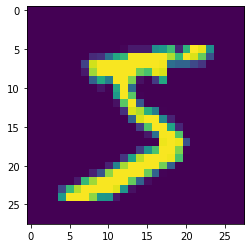

In [3]:
index = 0
print("Number:",y_train[index])
plt.imshow(x_train[index])

---
### データの加工
---
ダウンロードされた入力データは28x28pixelの画像データです。
ニューラル・ネットワークへの入力は2次元ではなく1次元での入力となるので28x28を平滑化し784パラメータ1次元で入力します。

また、このデータは0~255のグレースケールで与えられます。これを0から1に正規化するために全体を255で割っています。

In [0]:
num_image_shape = 784
x_train = x_train.reshape(x_train.shape[0], num_image_shape)
x_test  = x_test.reshape(x_test.shape[0], num_image_shape)
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255
x_test  /= 255

0~9までの手書きデータが与えられているため、10種類に分類する必要があります。

教師データをone-hot-vectorという形で表現します。

このような変換をするのは、分類先それぞれは数学的に独立しているためです。つまり、2+4=6であることは間違いないですが、2の画像と4の画像を足しても6の画像となることはありません。

下のコードで変換した出力データを確認してください。（コメントを外してください。）

In [0]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)
# print("y_test", y_test[0])

---
### モデルの構築
---
モデルを構築します。入力データの形は784個の1次元データとなります。
これに全結合層を複数つなげたネットワークを構築します。

出力ユニットの数は分類する種類の数（今回の例は0~9までの10種）になります。

In [0]:
def buildModel():
  model = keras.Sequential([
                            keras.layers.Dense(784, input_shape=(784,), activation='relu'),
                            keras.layers.Dense(256, activation='relu'),
                            keras.layers.Dense(128, activation='relu'),
                            keras.layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(),
             metrics=['accuracy'])
  model.summary()
  return model

---
### 学習
---
それぞれのデータを入力し学習させます。

In [7]:
model = buildModel()
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 850,586
Trainable params: 850,586
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 13s 209us/step - loss: 0.2636 -

---
### 学習結果の確認
---
学習の結果を確認します。学習に使用していないデータで検証を行います。
結果として98%の精度で分類できています。

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuraxy:',score[1])

Test loss: 0.07215710943471768
Test accuraxy: 0.9823


学習曲線を確認します。
両方とも精度（Accuracyは正確さなので厳密には違うものです）

一見テストデータが低そうですが両者とも95%以上の好結果が出ています。

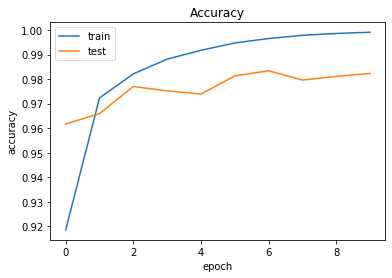

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

98%の精度を得たのでこれで十分のように思えます。しかしこのネットワークには致命的な欠陥が存在しています。

このモデルに対して自分の手書き文字を入力した場合、実は半分ほど判別できません。（約60％～70%）これにはもちろん理由があります。

それは画像内の文字が予め中央に配置されていることです。我々が自分で手書き入力した文字は中央に配置されていません。このネットワークでは位置関係によって認識が変わってしまうため、このような誤判定が増えてしまうのです。

他にも色々な欠点があり、MNISTでは高精度が出ていますが、実用上全結合層のみで構成されたネットワークはあまり性能がよくありません。


---
### 畳み込みニューラル・ネットワーク
---
畳み込みニューラル・ネットワークで前述の位置関係によって認識できなくなるといった問題を軽減することができます。

層の中身は画像処理におけるフィルターに酷似しています。

まず、入力するデータを2次元に戻します。色部分の次元を含め１データあたり３次元のデータに変換します。（28x28x1）

In [0]:
img_pixel = 28
colors = 1
x_train = x_train.reshape(x_train.shape[0], img_pixel, img_pixel, colors)
x_test  = x_test.reshape(x_test.shape[0], img_pixel, img_pixel, colors)

---
### 畳み込みニューラル・ネットワークの構築
---


本来であれば複雑なアルゴリズムの実装をしなければならないところですが、Kerasにすでに２次元の畳込みネットワーク実装されています。（Conv2D）

またプーリングや平滑化なども実装されており、非常に簡単にネットワークを構築することが可能です。

In [0]:
def buildCnnModel(input_shape):
  model = keras.Sequential([
    keras.layers.Conv2D(28, (3,3), activation='relu', input_shape=input_shape),
    keras.layers.Conv2D(56, (3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(),
             metrics=['accuracy'])
  model.summary()
  return model

---
### 学習（CNN）
---
学習の際のパラメータは先程と同じ条件で行います。

学習可能な重み（パラメータ）はより増加し、１００万を超えています。（先程は８５万）

In [13]:
model = buildCnnModel(input_shape=x_train[0].shape)
hist = model.fit(x_train, y_train,
         batch_size=128,
         epochs=10,
         verbose=1,
         validation_data=(x_test, y_test))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 56)        14168     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 56)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 56)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8064)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1032320   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

---
### 学習結果の確認（CNN）
---
学習した結果、全結合層のみで構築したネットワークよりもより良い精度が出ます。

また、自ら手書きした文字を入力した際でもある程度精度が向上しているはずです。

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuraxy:',score[1])

Test loss: 0.024675600505883723
Test accuraxy: 0.9921


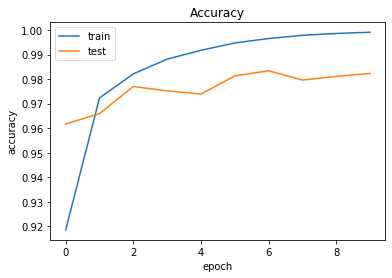

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()